In [33]:
# Proyecto de GLM - Modelo de Frecuencia
# Realizado por: 52960729- Johanna Patricia Barrantes Bohórquez
# Fecha: 31 de marzo de 2025
# Maestria Analisis y Gerencia de Datos


import sys
import os
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math
import patsy

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.discrete.count_model import ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP
warnings.filterwarnings("ignore")

In [34]:
sys.path.append('/content/src/')
from Funciones_JPBB import *

# Configuración de directorios y columnas
directory_path = '/content/'
file_pattern = 'part-*.parquet'
# Reducimos las variables en Factores, eliminando las no relevantes o redundantes
Factores = [
"Etiq_AGUAACAGBC", "antigedif", "Altitud", "Pluviometria_anual",
    "renta_bruta_media", "FLRF_RISK", "Flood_AVG", "PREC_ERA5_10Y"
]
Variables_clave = ["stro_Corr_AGUAACAGBC", "exp_corr_ACAGBC", "CUPD_CAP_Corr_aguaacagbc"]
columns = Factores + Variables_clave

# 1. Cargar datos (sin filtrar ceros)
df = load_and_process_data(directory_path, file_pattern, columns)

# Verificar las columnas disponibles en el DataFrame
print("\nColumnas disponibles en el DataFrame después de cargar los datos:")
print(df.columns.tolist())


📂 Cargando archivo: /content/part-00000-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00001-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00002-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00003-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
📂 Cargando archivo: /content/part-00004-20e0f4c4-2272-4aa2-bbed-9c3ff84c37b8-c000.snappy.parquet
✅ Datos cargados y procesados correctamente. Total de filas: 151447

Columnas disponibles en el DataFrame después de cargar los datos:
['Etiq_AGUAACAGBC', 'antigedif', 'Altitud', 'Pluviometria_anual', 'renta_bruta_media', 'FLRF_RISK', 'Flood_AVG', 'PREC_ERA5_10Y', 'stro_Corr_AGUAACAGBC', 'exp_corr_ACAGBC', 'CUPD_CAP_Corr_aguaacagbc', 'frecuencia', 'severidad']


In [35]:
# Corregir errores de codificación (reemplazar -9999 con NaN)
print("\nCorrigiendo errores de codificación (reemplazando -9999 con NaN)...")
for col in ['PREC_ERA5_10Y','FLRF_RISK']:
    df[col] = df[col].replace(-9999, np.nan)


Corrigiendo errores de codificación (reemplazando -9999 con NaN)...


In [36]:
generar_resumen_exploratorio(df, Factores)

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers,#Categorías
1,Altitud,Numérico,1529,149918,412.940000,659.000000,4.000000,2326.000000,271.000000,0.18%,nan
4,FLRF_RISK,Numérico,14128,137319,0.650000,0.000000,0.000000,9.000000,19889.000000,14.48% ⚠️,nan
5,Flood_AVG,Numérico,2391,149056,1.140000,0.000000,0.000000,8.740000,8714.000000,5.85%,nan
6,PREC_ERA5_10Y,Numérico,11449,139998,53.900000,41.659451,31.180000,102.340000,268.000000,0.19%,nan
2,Pluviometria_anual,Numérico,1529,149918,575.270000,469.000000,156.000000,2181.000000,20343.000000,13.57% ⚠️,nan
0,antigedif,Numérico,0,151447,42.340000,50.000000,0.000000,123.000000,3293.000000,2.17%,nan
3,renta_bruta_media,Numérico,1323,150124,14866.750000,22162.343027,5237.200000,43075.740000,1770.000000,1.18%,nan
7,Etiq_AGUAACAGBC,Categórico,0,151447,nan,Valores coherentes,nan,nan,nan,nan,2.000000


In [37]:
df.describe()

,antigedif,Altitud,Pluviometria_anual,renta_bruta_media,FLRF_RISK,Flood_AVG,PREC_ERA5_10Y,stro_Corr_AGUAACAGBC,exp_corr_ACAGBC,CUPD_CAP_Corr_aguaacagbc,frecuencia,severidad
count,151447.000000,149918.000000,149918.000000,150124.000000,137319.000000,149056.000000,139998.000000,151447.0,151447.000000,151447.000000,151447.000000,151447.000000
mean,42.340495,412.940219,575.270323,14866.748685,0.650260,1.135814,53.898155,1.0,0.318203,442.702005,25.294126,442.702005
std,19.765847,301.350652,263.798294,4588.761671,1.750913,1.143922,13.488577,0.0,0.279701,571.718171,69.881936,571.718171
min,0.000000,4.000000,156.000000,5237.203252,0.000000,0.000000,31.178094,1.0,0.002732,0.010000,1.000000,0.010000
25%,27.000000,132.000000,451.000000,11460.289114,0.000000,0.359006,41.659451,1.0,0.082192,53.700000,1.983696,53.700000
50%,45.000000,339.000000,479.000000,14197.487760,0.000000,0.772162,51.863943,1.0,0.240437,195.500000,4.159091,195.500000
75%,53.000000,659.000000,595.000000,17133.939907,0.000000,1.528628,65.136301,1.0,0.504110,553.385000,12.166667,553.385000
max,123.000000,2326.000000,2181.000000,43075.740629,9.000000,8.739552,102.335587,1.0,1.000000,2500.000000,366.000000,2500.000000


['Etiq_AGUAACAGBC', 'antigedif', 'Altitud', 'Pluviometria_anual', 'renta_bruta_media', 'FLRF_RISK', 'Flood_AVG', 'PREC_ERA5_10Y']


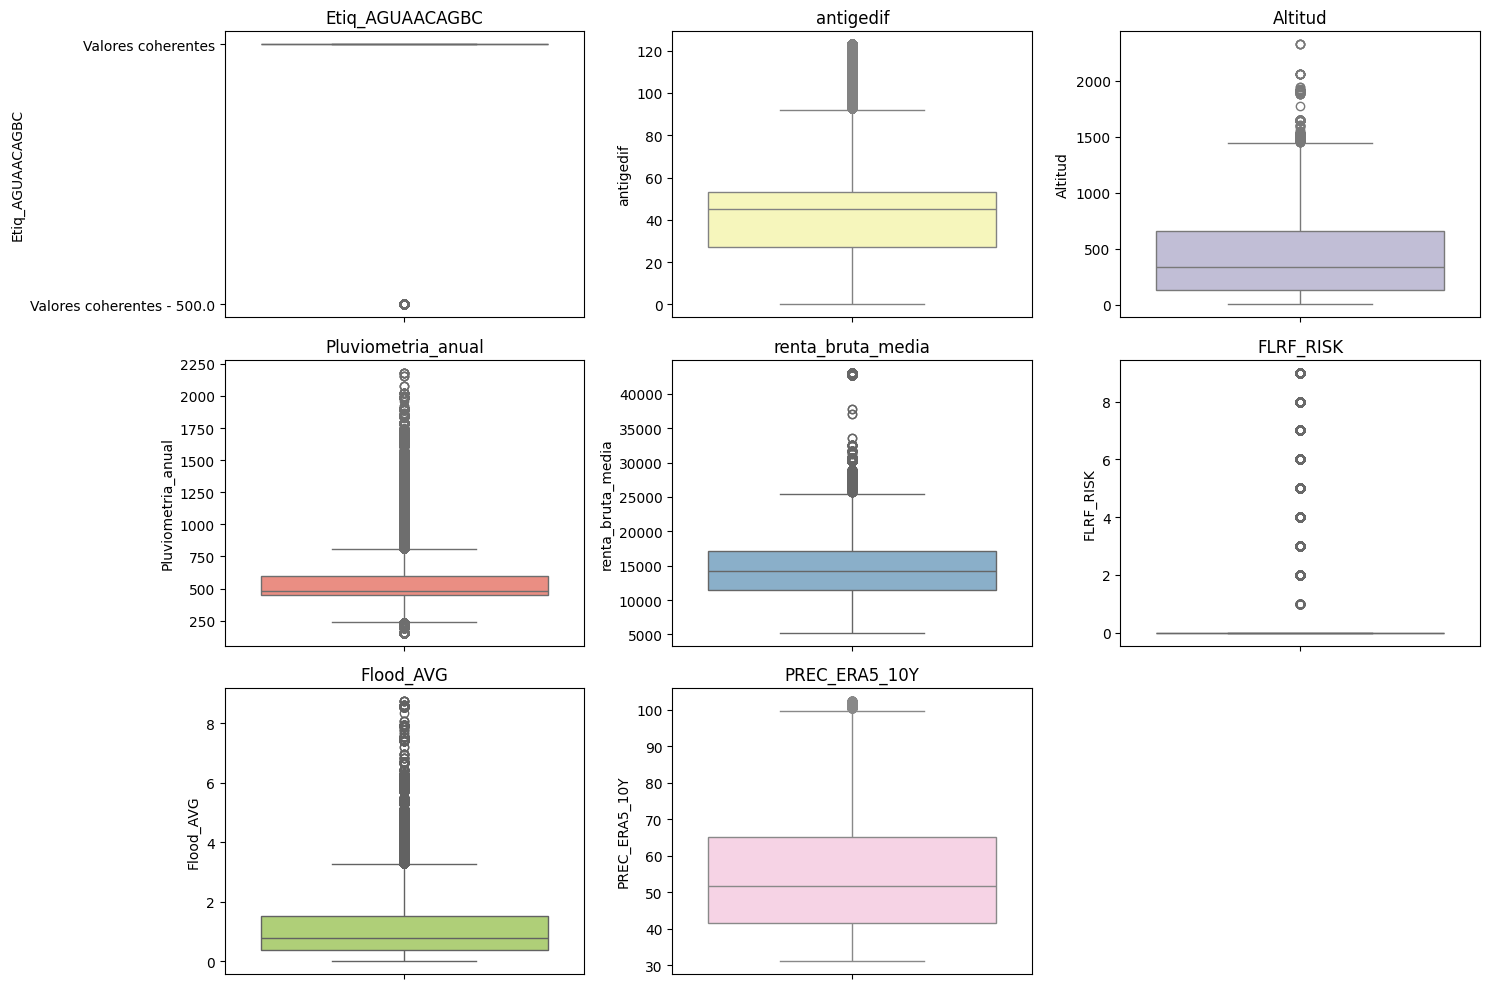

In [38]:

print(Factores)  # Lista de nombres de columnas numéricas
generar_boxplots(df, Factores)

In [39]:
# 4.2 Imputar valores nulos
print("\nImputando valores nulos en variables numéricas con la mediana...")
numeric_columns = ["Altitud", "FLRF_RISK", "Flood_AVG", "PREC_ERA5_10Y", "Pluviometria_anual", "renta_bruta_media"]
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].median())
print("✅ Imputación de valores nulos completada.")


Imputando valores nulos en variables numéricas con la mediana...
✅ Imputación de valores nulos completada.


In [40]:
print("\nImputando valores nulos en variables categóricas con la moda...")
categorical_columns = ["Etiq_AGUAACAGBC"]
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
print("✅ Imputación de valores nulos en categóricas completada.")


Imputando valores nulos en variables categóricas con la moda...
✅ Imputación de valores nulos en categóricas completada.


In [41]:
# Ajustar outliers mediante winsorización
print("\nAjustando outliers mediante winsorización...")
df = ajustar_outliers_winsorizacion(df, numeric_columns, percentil_bajo=0.01, percentil_alto=0.99)
print("✅ Outliers ajustados.")


Ajustando outliers mediante winsorización...
✅ Outliers ajustados.


In [44]:
# Generar resumen exploratorio
generar_resumen_exploratorio(df, Factores)

,Variable,Tipo,Nulos,Cantidad,Promedio,Moda,Min,Max,Outliers (IQR),% Outliers,#Categorías
1,Altitud,Numérico,0,151447,410.990000,659.000000,25.000000,1174.000000,0.000000,0.0%,nan
4,FLRF_RISK,Numérico,0,151447,0.590000,0.000000,0.000000,8.000000,19889.000000,13.13% ⚠️,nan
5,Flood_AVG,Numérico,0,151447,1.120000,0.000000,0.000000,5.790000,8984.000000,5.93%,nan
6,PREC_ERA5_10Y,Numérico,0,151447,53.740000,51.863943,34.620000,98.140000,0.000000,0.0%,nan
2,Pluviometria_anual,Numérico,0,151447,572.480000,469.000000,232.000000,1497.000000,20372.000000,13.45% ⚠️,nan
0,antigedif,Numérico,0,151447,42.340000,50.000000,0.000000,123.000000,3293.000000,2.17%,nan
3,renta_bruta_media,Numérico,0,151447,14828.480000,22162.343027,7363.050000,27384.850000,1793.000000,1.18%,nan
7,Etiq_AGUAACAGBC,Categórico,0,151447,nan,Valores coherentes,nan,nan,nan,nan,2.000000


In [43]:
df["exp_corr_ACAGBC"].replace(0, np.nan, inplace=True)  # Evita divisiones por cero
df.dropna(subset=["exp_corr_ACAGBC"], inplace=True)  # Elimina filas con valores nulos después del reemplazo

In [45]:
missing_summary = df[Factores].isnull().sum()
print("Cantidad de valores nulos por factor:")
print(missing_summary[missing_summary > 0].sort_values(ascending=False))

resumen_valores_nulos(df, Factores)

Cantidad de valores nulos por factor:
Series([], dtype: int64)


,Valores Nulos,Porcentaje (%)



🔍 **Top factores correlacionados con FRECUENCIA:** ['antigedif', 'renta_bruta_media', 'PREC_ERA5_10Y', 'Altitud', 'Pluviometria_anual']
🔍 **Top factores correlacionados con SEVERIDAD:** ['Pluviometria_anual', 'renta_bruta_media', 'antigedif', 'Flood_AVG', 'PREC_ERA5_10Y']


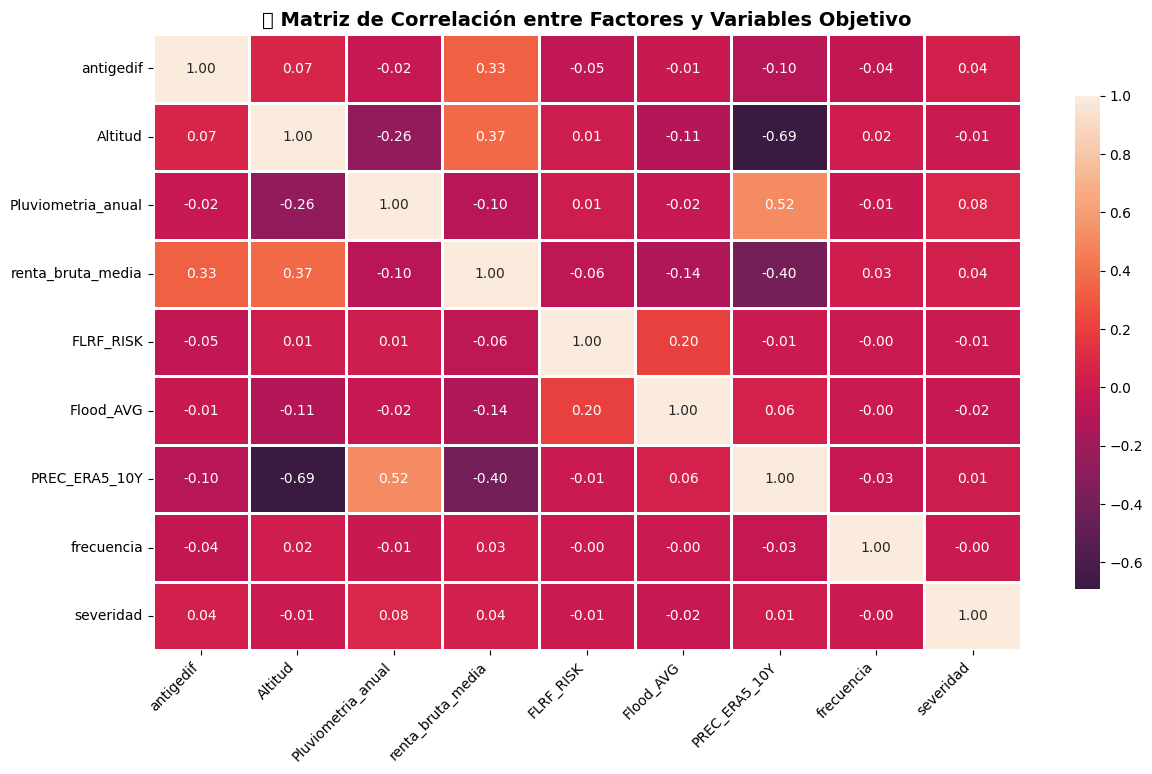

In [46]:
top_frecuencia, top_severidad = analizar_correlacion(df, Factores, cmap="rocket")

In [47]:
import patsy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
factores_freq_1 = ['antigedif', 'renta_bruta_media', 'PREC_ERA5_10Y', 'Altitud', 'Pluviometria_anual']
factores_freq_2 = Factores  # modelo completo

# Modelo 1: solo FLRJ_RISK
formula_freq_1 = "frecuencia ~ " + " + ".join(factores_freq_1)
yf1, Xf1 = patsy.dmatrices(formula_freq_1, data=df, return_type='dataframe')
result_f1 = sm.GLM(yf1, Xf1, family=sm.families.Poisson()).fit()
df_f1 = yf1.copy()
df_f1["pred"] = result_f1.predict(Xf1)

# Modelo 2: completo
factores_formula = " + ".join([f"C({f})" if df[f].dtype == "object" else f for f in factores_freq_2])
formula_freq_2 = f"frecuencia ~ {factores_formula}"
yf2, Xf2 = patsy.dmatrices(formula_freq_2, data=df, return_type='dataframe')
result_f2 = sm.GLM(yf2, Xf2, family=sm.families.Poisson()).fit()
df_f2 = yf2.copy()
df_f2["pred"] = result_f2.predict(Xf2)

# Modelo 3 reducido de FRECUENCIA
formula_freq_reducido = "frecuencia ~ " + " + ".join(top_frecuencia)
yfr, Xfr = patsy.dmatrices(formula_freq_reducido, data=df, return_type='dataframe')
result_frecuencia_red = sm.GLM(yfr, Xfr, family=sm.families.Poisson()).fit()
df_fr_eval = yfr.copy()
df_fr_eval["pred"] = result_frecuencia_red.predict(Xfr)



📊 Frecuencia - Modelo 1 (Etiq_AGUAACAGBC)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9954e+06
Date:                Fri, 11 Apr 2025   Deviance:                   1.1434e+07
Time:                        14:34:45   Pearson chi2:                 2.90e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5428
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

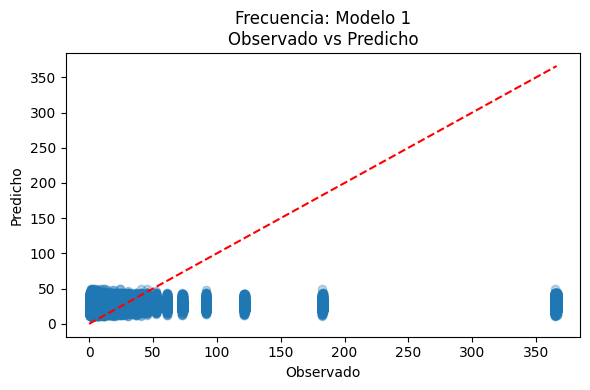

In [48]:
# Métricas y gráficos
print("\n📊 Frecuencia - Modelo 1 (Etiq_AGUAACAGBC)")
print(result_f1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f1["frecuencia"], df_f1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f1["frecuencia"], df_f1["pred"], alpha=0.3)
plt.plot([0, df_f1["frecuencia"].max()], [0, df_f1["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Frecuencia - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151438
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9921e+06
Date:                Fri, 11 Apr 2025   Deviance:                   1.1427e+07
Time:                        14:34:49   Pearson chi2:                 2.90e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5623
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

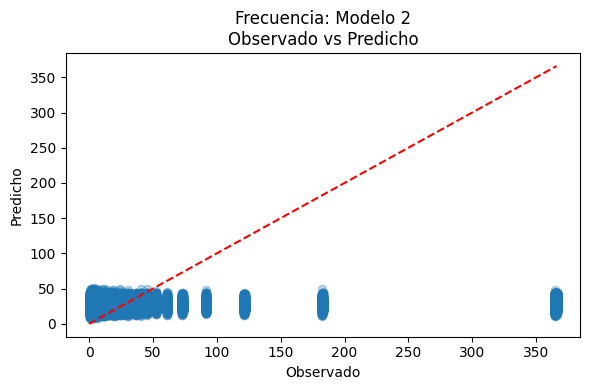

In [49]:
print("\n📊 Frecuencia - Modelo 2 (Completo)")
print(result_f2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_f2["frecuencia"], df_f2["pred"], alpha=0.3)
plt.plot([0, df_f2["frecuencia"].max()], [0, df_f2["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Frecuencia - Modelo 3 (Frecuencia)
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9954e+06
Date:                Fri, 11 Apr 2025   Deviance:                   1.1434e+07
Time:                        14:34:54   Pearson chi2:                 2.90e+07
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5428
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

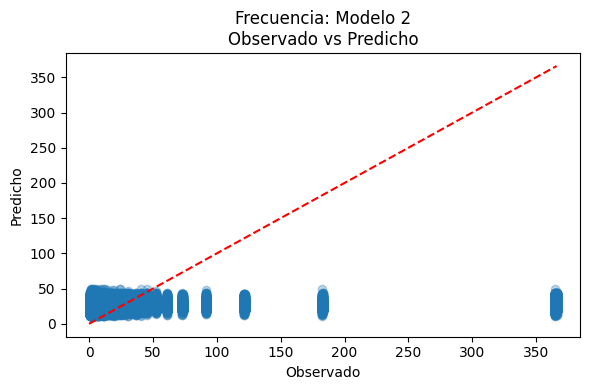

In [50]:
print("\n📊 Frecuencia - Modelo 3 (Frecuencia)")
print(result_frecuencia_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_fr_eval["frecuencia"], df_fr_eval["pred"], alpha=0.3)
plt.plot([0, df_fr_eval["frecuencia"].max()], [0, df_fr_eval["frecuencia"].max()], 'r--')
plt.title("Frecuencia: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

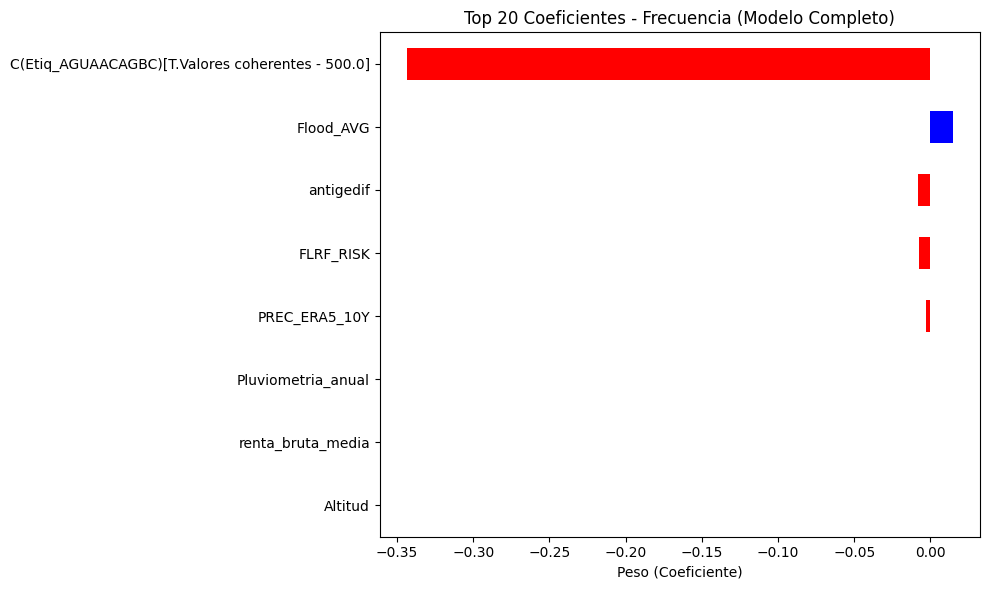

In [51]:
# Importancia de variables - Frecuencia (sin intercepto)
coef_freq = result_f2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_freq.head(20)]
plt.figure(figsize=(10, 6))
coef_freq.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Frecuencia (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [52]:
# -----------------------------
# Parte 2: SEVERIDAD - Evaluar dos modelos
# -----------------------------
df_sev = df[df["severidad"] > 0].copy()
factores_sev_1 = ['Pluviometria_anual', 'renta_bruta_media', 'antigedif', 'Flood_AVG', 'PREC_ERA5_10Y']
factores_sev_2 = Factores  # modelo completo

# Modelo 1: solo antigüedad
formula_sev_1 = "severidad ~ " + " + ".join(factores_sev_1)
ys1, Xs1 = patsy.dmatrices(formula_sev_1, data=df_sev, return_type='dataframe')
result_s1 = sm.GLM(ys1, Xs1, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s1 = ys1.copy()
df_s1["pred"] = result_s1.predict(Xs1)

# Modelo 2: completo
factores_formula_sev = " + ".join([f"C({f})" if df_sev[f].dtype == "object" else f for f in factores_sev_2])
formula_sev_2 = f"severidad ~ {factores_formula_sev}"
ys2, Xs2 = patsy.dmatrices(formula_sev_2, data=df_sev, return_type='dataframe')
result_s2 = sm.GLM(ys2, Xs2, family=sm.families.Gamma(sm.families.links.log())).fit()
df_s2 = ys2.copy()
df_s2["pred"] = result_s2.predict(Xs2)

# Modelo 3 reducido a los factores significativos
formula_sev_reducido = "severidad ~ " + " + ".join(top_severidad)
df_sev_red = df[df["severidad"] > 0].copy()
ysr, Xsr = patsy.dmatrices(formula_sev_reducido, data=df_sev_red, return_type='dataframe')
result_severidad_red = sm.GLM(ysr, Xsr, family=sm.families.Gamma(sm.families.links.log())).fit()
df_sr_eval = ysr.copy()
df_sr_eval["pred"] = result_severidad_red.predict(Xsr)


📊 Severidad - Modelo 1 (Antigüedad)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          1.6424
Method:                          IRLS   Log-Likelihood:            -1.0755e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1624e+05
Time:                        14:35:19   Pearson chi2:                 2.49e+05
No. Iterations:                    12   Pseudo R-squ. (CS):           0.009417
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

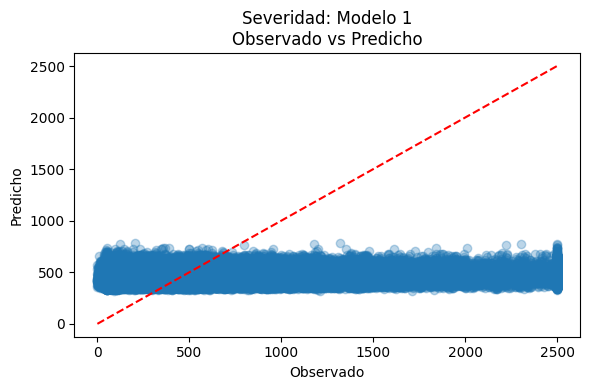

In [53]:
# Métricas y gráficos
print("\n📊 Severidad - Modelo 1 (Antigüedad)")
print(result_s1.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s1["severidad"], df_s1["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s1["severidad"], df_s1["pred"], alpha=0.3)
plt.plot([0, df_s1["severidad"].max()], [0, df_s1["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 1\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()


📊 Severidad - Modelo 2 (Completo)
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151438
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                          1.6461
Method:                          IRLS   Log-Likelihood:            -1.0755e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1615e+05
Time:                        14:35:26   Pearson chi2:                 2.49e+05
No. Iterations:                    14   Pseudo R-squ. (CS):           0.009752
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

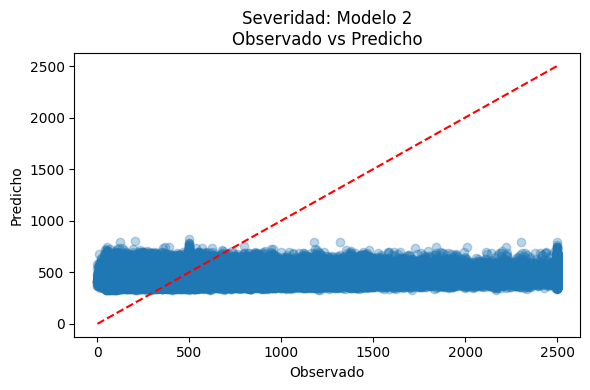

In [54]:
print("\n📊 Severidad - Modelo 2 (Completo)")
print(result_s2.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_s2["severidad"], df_s2["pred"], alpha=0.3)
plt.plot([0, df_s2["severidad"].max()], [0, df_s2["severidad"].max()], 'r--')
plt.title("Severidad: Modelo 2\nObservado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

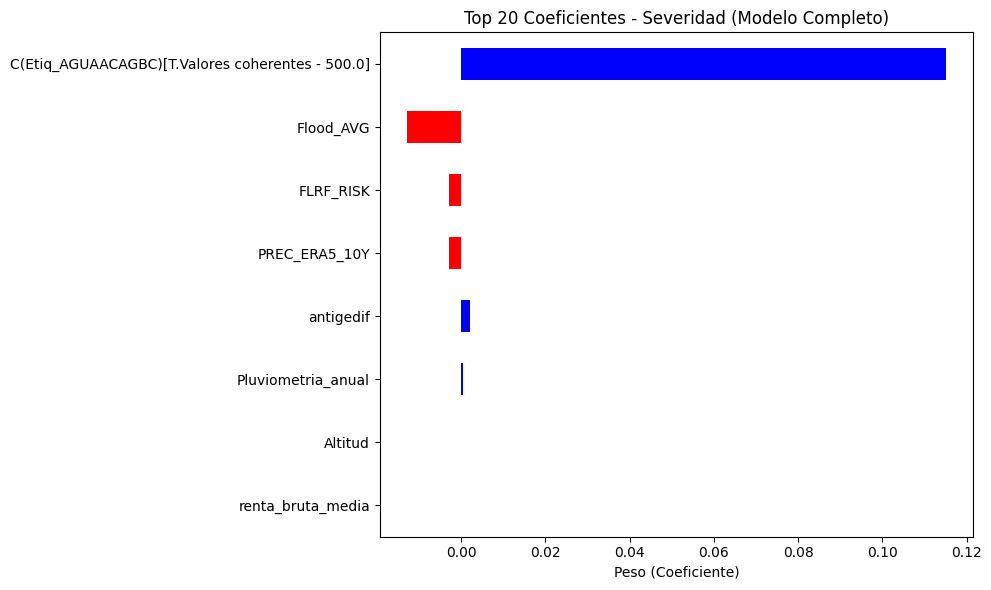

In [55]:
# Importancia de variables - Severidad (sin intercepto)
coef_sev = result_s2.params.drop("Intercept").sort_values(key=abs, ascending=False)
colors = ["blue" if c > 0 else "red" for c in coef_sev.head(20)]
plt.figure(figsize=(10, 6))
coef_sev.head(20).plot(kind='barh', color=colors)
plt.title("Top 20 Coeficientes - Severidad (Modelo Completo)")
plt.xlabel("Peso (Coeficiente)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 Modelo Reducido - Severidad
                 Generalized Linear Model Regression Results                  
Dep. Variable:              severidad   No. Observations:               151447
Model:                            GLM   Df Residuals:                   151441
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                          1.6424
Method:                          IRLS   Log-Likelihood:            -1.0755e+06
Date:                Fri, 11 Apr 2025   Deviance:                   2.1624e+05
Time:                        14:35:34   Pearson chi2:                 2.49e+05
No. Iterations:                    12   Pseudo R-squ. (CS):           0.009417
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

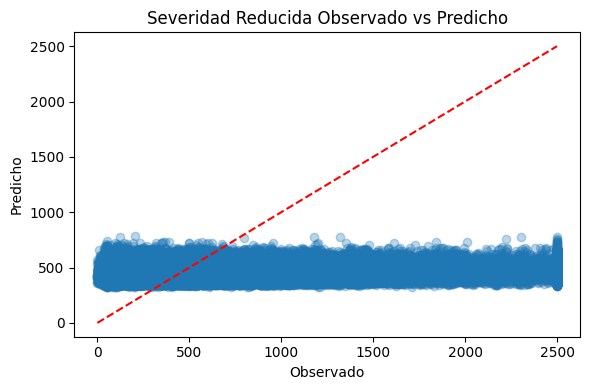

In [56]:
# Modelo reducido a los factores significativos

print("📊 Modelo Reducido - Severidad")
print(result_severidad_red.summary())
print("RMSE:", np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"])))

plt.figure(figsize=(6, 4))
plt.scatter(df_sr_eval["severidad"], df_sr_eval["pred"], alpha=0.3)
plt.plot([0, df_sr_eval["severidad"].max()], [0, df_sr_eval["severidad"].max()], 'r--')
plt.title("Severidad Reducida Observado vs Predicho")
plt.xlabel("Observado")
plt.ylabel("Predicho")
plt.tight_layout()
plt.show()

Pseudo R² Frecuencia - Completo: 0.0108
Pseudo R² Frecuencia - Reducido: 0.0103
Pseudo R² Severidad - Completo: 0.0112
Pseudo R² Severidad - Reducido: 0.0108


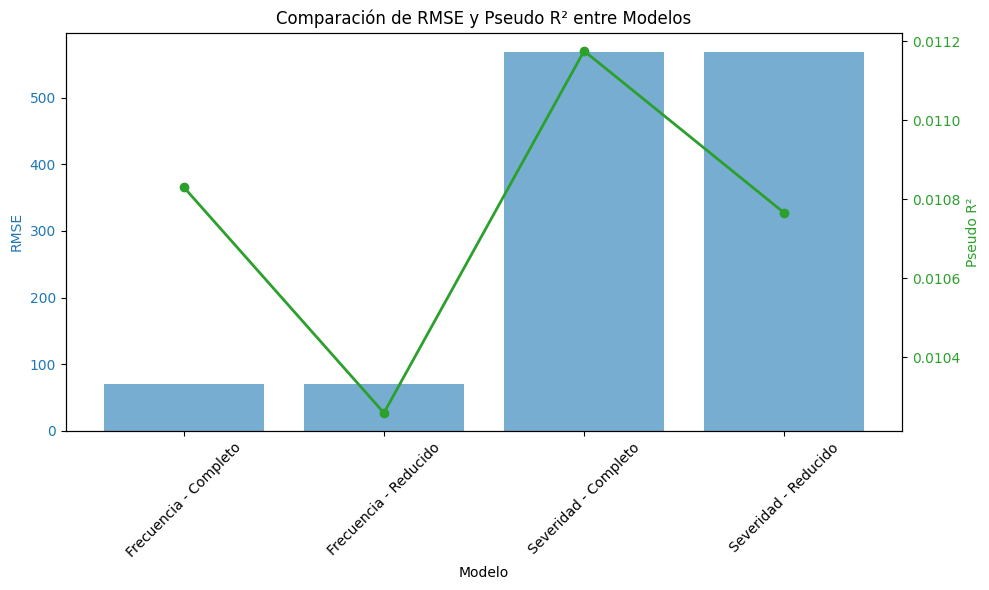

In [57]:
# -----------------------------
# Paso Extra: Cálculo de Pseudo R² para modelos GLM

# Pseudo R² para Frecuencia - Modelo Completo
null_model_f2 = sm.GLM(yf2, np.ones((yf2.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_f2 = 1 - result_f2.deviance / null_model_f2.deviance
print(f"Pseudo R² Frecuencia - Completo: {pseudo_r2_f2:.4f}")

# Pseudo R² para Frecuencia - Modelo Reducido
null_model_fr = sm.GLM(yfr, np.ones((yfr.shape[0], 1)), family=sm.families.Poisson()).fit()
pseudo_r2_fr = 1 - result_frecuencia_red.deviance / null_model_fr.deviance
print(f"Pseudo R² Frecuencia - Reducido: {pseudo_r2_fr:.4f}")

# Pseudo R² para Severidad - Modelo Completo
null_model_s2 = sm.GLM(ys2, np.ones((ys2.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_s2 = 1 - result_s2.deviance / null_model_s2.deviance
print(f"Pseudo R² Severidad - Completo: {pseudo_r2_s2:.4f}")

# Pseudo R² para Severidad - Modelo Reducido
null_model_sr = sm.GLM(ysr, np.ones((ysr.shape[0], 1)), family=sm.families.Gamma(sm.families.links.log())).fit()
pseudo_r2_sr = 1 - result_severidad_red.deviance / null_model_sr.deviance
print(f"Pseudo R² Severidad - Reducido: {pseudo_r2_sr:.4f}")

# Gráfico comparativo de RMSE y Pseudo R²
# Calcular RMSE para los modelos antes de usarlos en metrics_df
rmse_frec_completo = np.sqrt(mean_squared_error(df_f2["frecuencia"], df_f2["pred"]))
rmse_frec_reducido = np.sqrt(mean_squared_error(df_fr_eval["frecuencia"], df_fr_eval["pred"]))
rmse_sev_completo = np.sqrt(mean_squared_error(df_s2["severidad"], df_s2["pred"]))
rmse_sev_reducido = np.sqrt(mean_squared_error(df_sr_eval["severidad"], df_sr_eval["pred"]))

# Gráfico comparativo de RMSE y Pseudo R²
metrics_df = pd.DataFrame({
    "Modelo": [
        "Frecuencia - Completo", "Frecuencia - Reducido",
        "Severidad - Completo", "Severidad - Reducido"
    ],
    "RMSE": [
        rmse_frec_completo, rmse_frec_reducido,
        rmse_sev_completo, rmse_sev_reducido
    ],
    "Pseudo R²": [
        pseudo_r2_f2, pseudo_r2_fr,
        pseudo_r2_s2, pseudo_r2_sr
    ]
})

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel("Modelo")
ax1.set_ylabel("RMSE", color=color)
ax1.bar(metrics_df["Modelo"], metrics_df["RMSE"], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Pseudo R²", color=color)
ax2.plot(metrics_df["Modelo"], metrics_df["Pseudo R²"], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Comparación de RMSE y Pseudo R² entre Modelos")
plt.tight_layout()
plt.show()
